<a href="https://colab.research.google.com/github/yardsale8/probability_simulations_in_R/blob/main/2_6_plotting_estimated_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(tidyverse)
library(devtools)
install_github('yardsale8/purrrfect', force = TRUE)
library(purrrfect)

# Plotting and Summarizing Simulated Distributions

In this notebook, we will look as stacking the results of simple and parametric simulations to allow for tabulating and summarizing the resulting distribution.

# Plotting the Estimated Distrubiton

Stacking the outcomes, will allow us to plot the estimated distributions, using either

1. The estimated probability mass function,
2. The estimated cumulative distribution function (CDF), or
3. Comparing the observed and theoretical distributions with a probability-probability (p-p) plot.

### Review - Probability mass function (PMF)

Let $X$ be a discrete random variable, the the **probability mass function (PMF)** is given by

$$p(x) = P(X = x)$$

for all $x\in \mathbb{R}$.

#### Example - Plotting the PMF for a waiting time problem.

Suppose that are are rolling a fair, 6-sided die until we see a roll of 5 or 6.  This is a compound--but not parametric--simultion.  Let's plote the estimated PMF

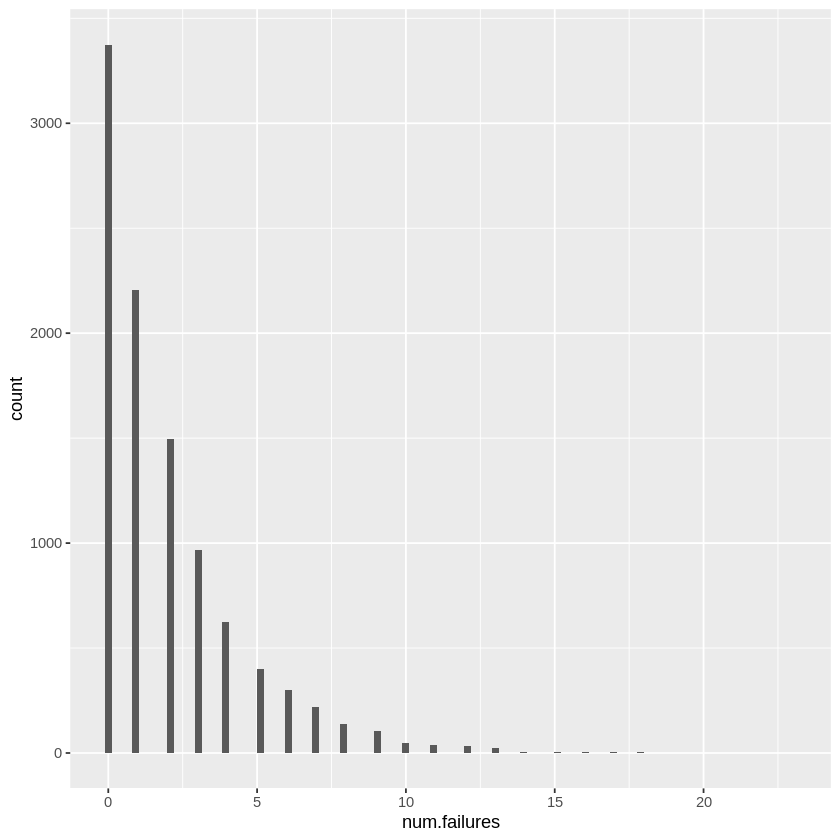

In [ ]:
is.success <- \(x) x >= 5
one.success <- \(x) num_successes(x, is.success)
die <- 1:6
num.trials <- 10000
(replicate(num.trials, sample_until(die, one.success, replace=TRUE))
 %>% mutate(total.trials = map_int(.outcome, length),
            num.failures = total.trials - 1)
) -> waiting_times

ggplot(data = waiting_times) +
  geom_histogram(aes(x = num.failures), bins = 100)

### Plotting the CDF

Next, we will look at plotting the cumulative distribution function (CDF).  First, let's review

### Review - The cumulative distribution funciton (CDF)

Recall that the cumulative distribution function (CDF) of a random variable $X$ is the function $F$ such that

$$F(x) = P(X \le x)$$

 for all $x\in\mathbb{R}$.  We will be refering to this functions at the **theoretical CDF**.  



### Review -- The Empirical CDF

The **empirical CDF** is the sample estimate of said function, and is constructed by computing the fraction of the data at or below is observed value.  Let $s$ the sample represented as a multi-set (which allows for repeated values), then the **empirical CDF** is given by

$$\hat{F}(x)=\frac{1}{n}\sum_{k\in s} I(x \le k)$$.

for all $x\in\mathbb{R}$.  Here, $I$ is an [indicator function](https://en.wikipedia.org/wiki/Indicator_function), where $I(x \le k)$ will be 1 when $x \le k$, and zero otherwise.

### Computing empirical and theoretical CDFs in R

We can use the following functions to compute or estimate the CDF.

1. The window function `cume_dist` is applied to the outcome column to estimate the CDF of that point using the sample.  <font size=1>Note that in parametric simulations, we will need to group by the parameter(s) using the `.by` argument of `mutate`</font>
2. We can compute the theoretical CDF of the outcomes by mapping the parameters + observed value onto respective R "`p`" function, such at `pbinom` or `pnorm`.

#### Example - Plotting the empirical and theoretical CDF for a waiting time problem.

The previous experiment involved rolling a fair, 6-sided die until we see a roll of 5 or 6.  If $Y$ represents the number of failures until the first success, we know that $Y\sim Geom(1/3)$ and the theoretical CDF can be computed using the `pgeom` R function.

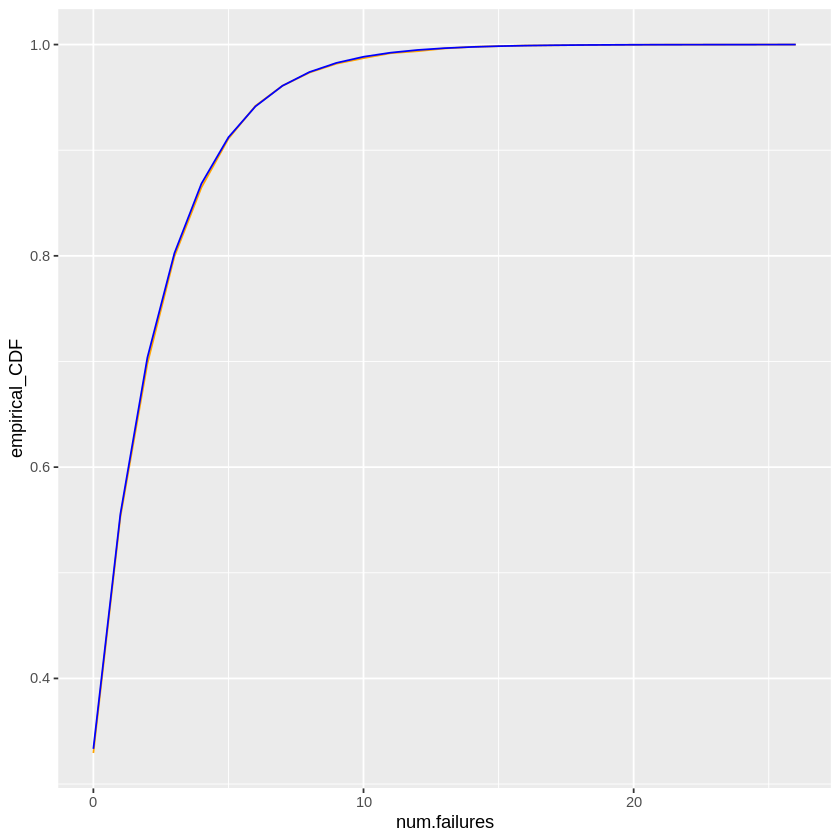

In [3]:
is.success <- \(x) x >= 5
one.success <- \(x) num_successes(x, is.success)
die <- 1:6
num.trials <- 10000
(replicate(num.trials, sample_until(die, one.success, replace=TRUE))
 %>% mutate(total.trials = map_int(.outcome, length),
            num.failures = total.trials - 1)
 %>% mutate(empirical_CDF = cume_dist(num.failures),
            theoretical_CDF = pgeom(num.failures, 1/3))
) -> waiting_times

 ggplot(data = waiting_times) +
   geom_line(aes(x = num.failures, y = empirical_CDF), color = "orange") +
   geom_line(aes(x = num.failures, y = theoretical_CDF), color = "blue")

#### Note on plotting a discrete CDF

While both the empirical and theoretical discrete CDFs are step-wise functions, it is convenient--and not too terribly misleading--to use a line plot.

### Creating a p-p plot

While the plots in the last example illustrated the similarity between the empirical and theoretical CDFs, the standard way of making this comparison is with a [p-p plot ](https://en.wikipedia.org/wiki/P%E2%80%93P_plot).  This is accomplished by making a scatterplot of the estimated and theoretical values of the CDF.  For convenience, we will also add the $y=x$ reference line (see below).

**Interpretation.** If the simulated data matches the theoretical distribution, $x$ and $y$ will be nearly identical and the points will be close to the reference line $y=x$.  On the other hand, if the observed data deviate from the theoretical distribution, the $x$ and $y$ values will differ and be distant from the reference line.

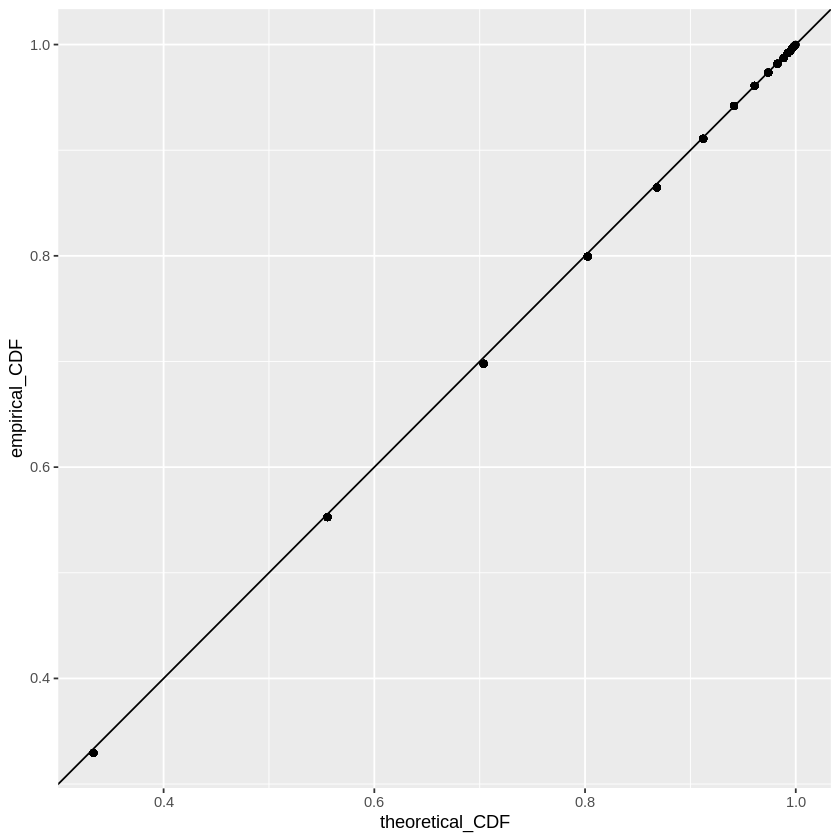

In [4]:
ggplot(data = waiting_times) +
   geom_abline(aes(slope = 1, intercept = 0)) +
   geom_point(aes(x = theoretical_CDF, y = empirical_CDF))

#### Why use a p-p plot?

There are a few reasons to use p-p (or q-q) plot over comparing the CDFs.

1. It is generally easier to deviations from a line,
2. The task is normalized regardless of the underlying distribution, and
3. It is possible to diagnose the type of deviation (skew, long tails, etc.).

## <font color="red"> Exercise 2.6.1 </font>

Suppose that $X$ and $Y$ are independent random variables with $X\sim gamma(\alpha = 2, \beta = 1)$ and $Y\sim gamma(\alpha = 3, \beta = 1)$.  Let $T = X + Y$.  It can be shown that $T\sim gamma(\alpha = 3 + 2, \beta = 1)$.

**Tasks.**

1. Explain why this result makes sense from a waiting time standpoint.
2. Use a simulating to verify this results by constructing all three types of plots (histogram, CDFs, and p-p plot).

<font color="orange">
Answer <b>1.</b> here.
</font>

In [5]:
# Your code for 2. here

## Plotting for parametric simulations

When working with a parametric simulation, where the distributions vary over a collection of one or more parameters, we will need to make the following adjustment when plotting.

1. We need to stack the trials by using `add_trials` after defining our parameter space with `parameters`,
2. Group on the parameter(s) when computing the empirical CDF using the `.by` argument in `mutate`, and
3. Add a `facet_grid` to our plot to facet on the parameter(s).

#### Stacking Outcomes and Plotting Parametric Simulations

The final option, not covered above, is to stack the outcomes in a simple, atomic column.  This approach is used primarily when plotting the distributions for each parameter or combination of parameters and has the advantage to this approach is simplier mutates (rarely need to map), but at the cost of spreading the related trials across multiple rows--requiring an extra grouped aggregation to accomplish other common task (e.g., estimating probabilities, expected values, quantiles, etc.).

### Example 2 - Simulating bionomial data over a set of sample sizes

Suppose we want to simulate the binomial distribution with a fixed $p=0.5$, but for the sample sizes $n\in\{5,10,15\}$.

Before plotting, we need to generate stacked outcomes over this parameter space.

#### The "shape" of a stacked parametric simulation.

1. Set up the parameter space using a `parameters`.
2. Add trials to convert the parameter space into an experimental notebook.
3. Use `map` or `pmap` to generate outcomes using the parameter column(s) as input.

#### Step 1 - Setting up the parameter space


In [ ]:
parameters(~n,
           seq(5,15,5))

n
<dbl>
5
10
15


#### Step 2 - Adding trials

Next, we need to replicate each parameter over a number of trials, which is accomplished using `add_trials`

In [ ]:
num.trials <- 5
(parameters(~n,
            seq(5,15,5))
 %>% add_trials(num.trials)
 )

n,.trial
<dbl>,<dbl>
5,1
5,2
5,3
5,4
5,5
10,1
10,2
10,3
10,4


#### Step 3 - Generating outcomes with `map`

To use map, we need to

1. Map onto the parameter column, and
2. Write a function that takes this parameter as input.

As alway, select the version of `map` that results in an atomic column type.  In this case, we will use `map_int`, as `rbinom` generates intergers.

In [ ]:
num.trials <- 5
p <- 0.5
(parameters(~n,
            seq(5,15,5))
 %>% add_trials(num.trials)
 %>% mutate(num.successes = map_int(n, \(n) rbinom(1, n, p)))
 )

n,.trial,num.successes
<dbl>,<dbl>,<int>
5,1,1
5,2,4
5,3,1
5,4,3
5,5,4
10,1,4
10,2,4
10,3,6
10,4,5


### Plotting the PMFs for each parameter.

Next, we use histograms to plot each of the PMFs using `facet_grid` to split the plots to one per value of $n$.

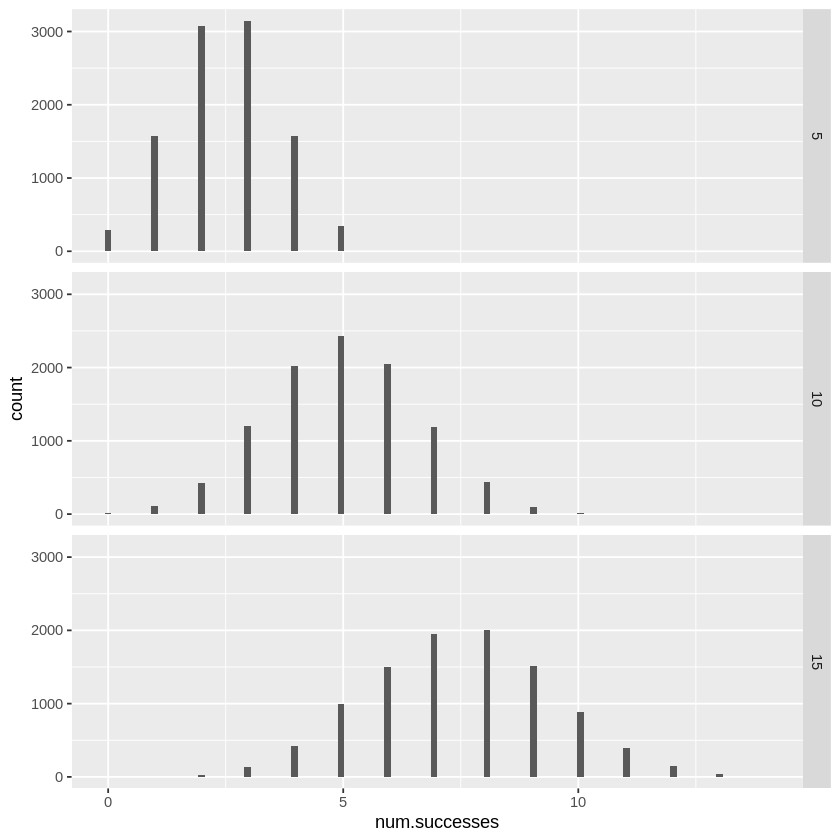

In [ ]:
# Test on small number of trials
num.trials <- 10000
p <- 0.5
(parameters(~n,
            seq(5,15,5))
 %>% add_trials(num.trials)
 %>% mutate(num.successes = map_int(n, \(n) rbinom(1, n, p)))
 ) -> trials

ggplot(trials) +
   geom_histogram(aes(x = num.successes), bins = 100) +
   facet_grid(rows = vars(n))


#### Plotting the empiritcal and theortical CDFs for many values of $n$ and $p$

When computing the empirical CDF, we need to group by the parameters using the `.by` argument of `mutate`

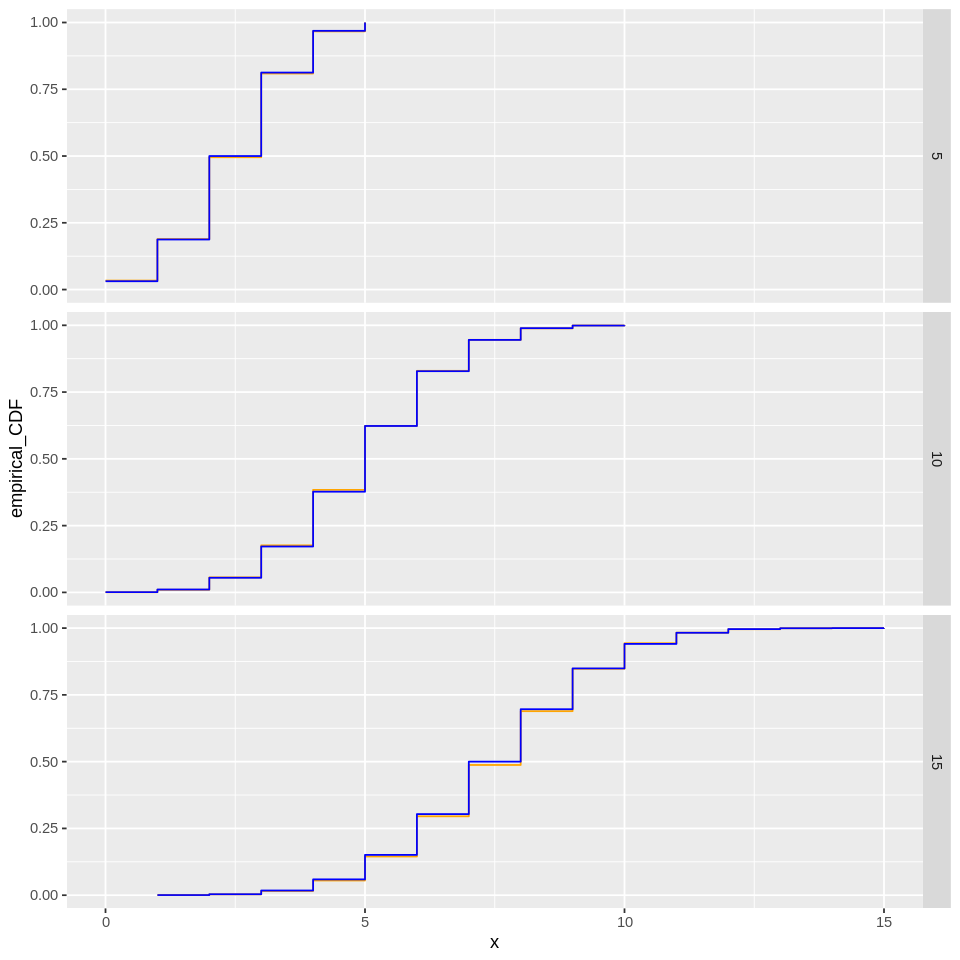

In [13]:
num.trials <- 10000
p <- 0.5
(parameters(~n,
        seq(5,15,5))
 %>% add_trials(num.trials)
 %>% mutate(x = map_int(n, \(n) rbinom(1, n, p)))
 %>% mutate(empirical_CDF = cume_dist(x), .by = n)
 %>% mutate(theoretical_CDF = map2_dbl(x, n, \(x,n) pbinom(x, n, p)))
 ) -> one_param_CDF_data

# Make plots wider (Colab only)
options(repr.plot.width=8, repr.plot.height=8)

# CDF_data
 ggplot(data = one_param_CDF_data) +
   geom_step(aes(x = x, y = empirical_CDF), color = "orange") +
   geom_step(aes(x = x, y = theoretical_CDF), color = "blue") +
  #  geom_line(aes(x = x, y = theoretical_CDF), color = "blue") + $ For continuous RV
   facet_grid(rows = vars(n))

### Plotting the p-p plot for each sample size

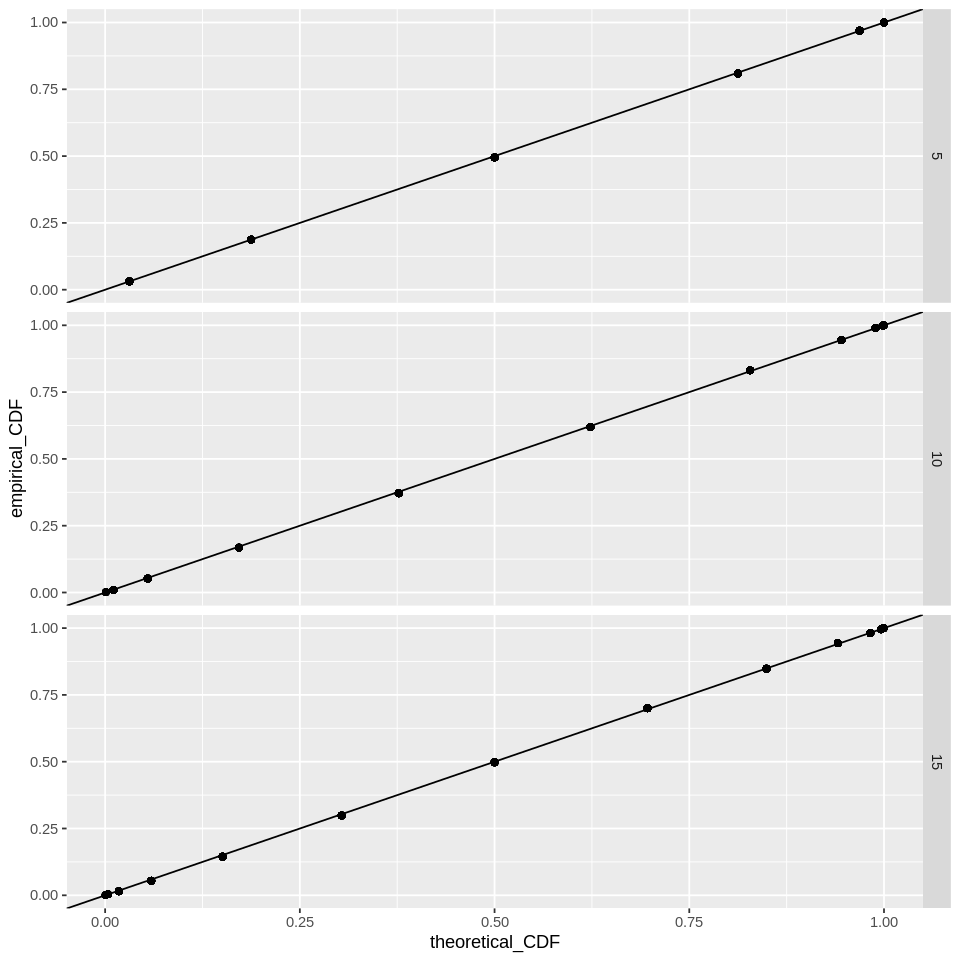

In [ ]:
ggplot(data = one_param_CDF_data) +
   geom_abline(aes(slope = 1, intercept = 0)) +
   geom_point(aes(x = theoretical_CDF, y = empirical_CDF)) +
   facet_grid(vars(n))

## <font color="red"> Exercise 2.6.2 </font>

Let $U$ be a random variable with $U\sim uniform(0,1)$.  Let $E = \frac{-\ln{U}}{\lambda}$ where $\lambda > 0$.  [It can be shown](https://en.wikipedia.org/wiki/Exponential_distribution#Random_variate_generation) that $E\sim exponential(\lambda)$

**Tasks.**

1. Run a parametric simulation over a number of values for $\lambda$ to verfiy the result.
2. Construct all three types of plots are part of your solution.

In [6]:
# Your code here


## Plotting the results of two parameter experiments

Finally, we will looks at plotting results for a two parameter simulations.  

### Example 3 - Plotting binomial trials for a two-parameter experiment.

Finally, suppose we want to visualized the estimated binomial distribution when varying both $p$ and $n$.  Note that

1. Both parameters are definite in the parameter space,
2. We need to use `map2_int` when mapping over the two parameters,
3. We need to can group by both parameters using `.by=c(n,p)` in `mutate`, and
4. We vary over both parameters in the `facet_grid`, as shoen below.

#### Plotting the esimated PMFs

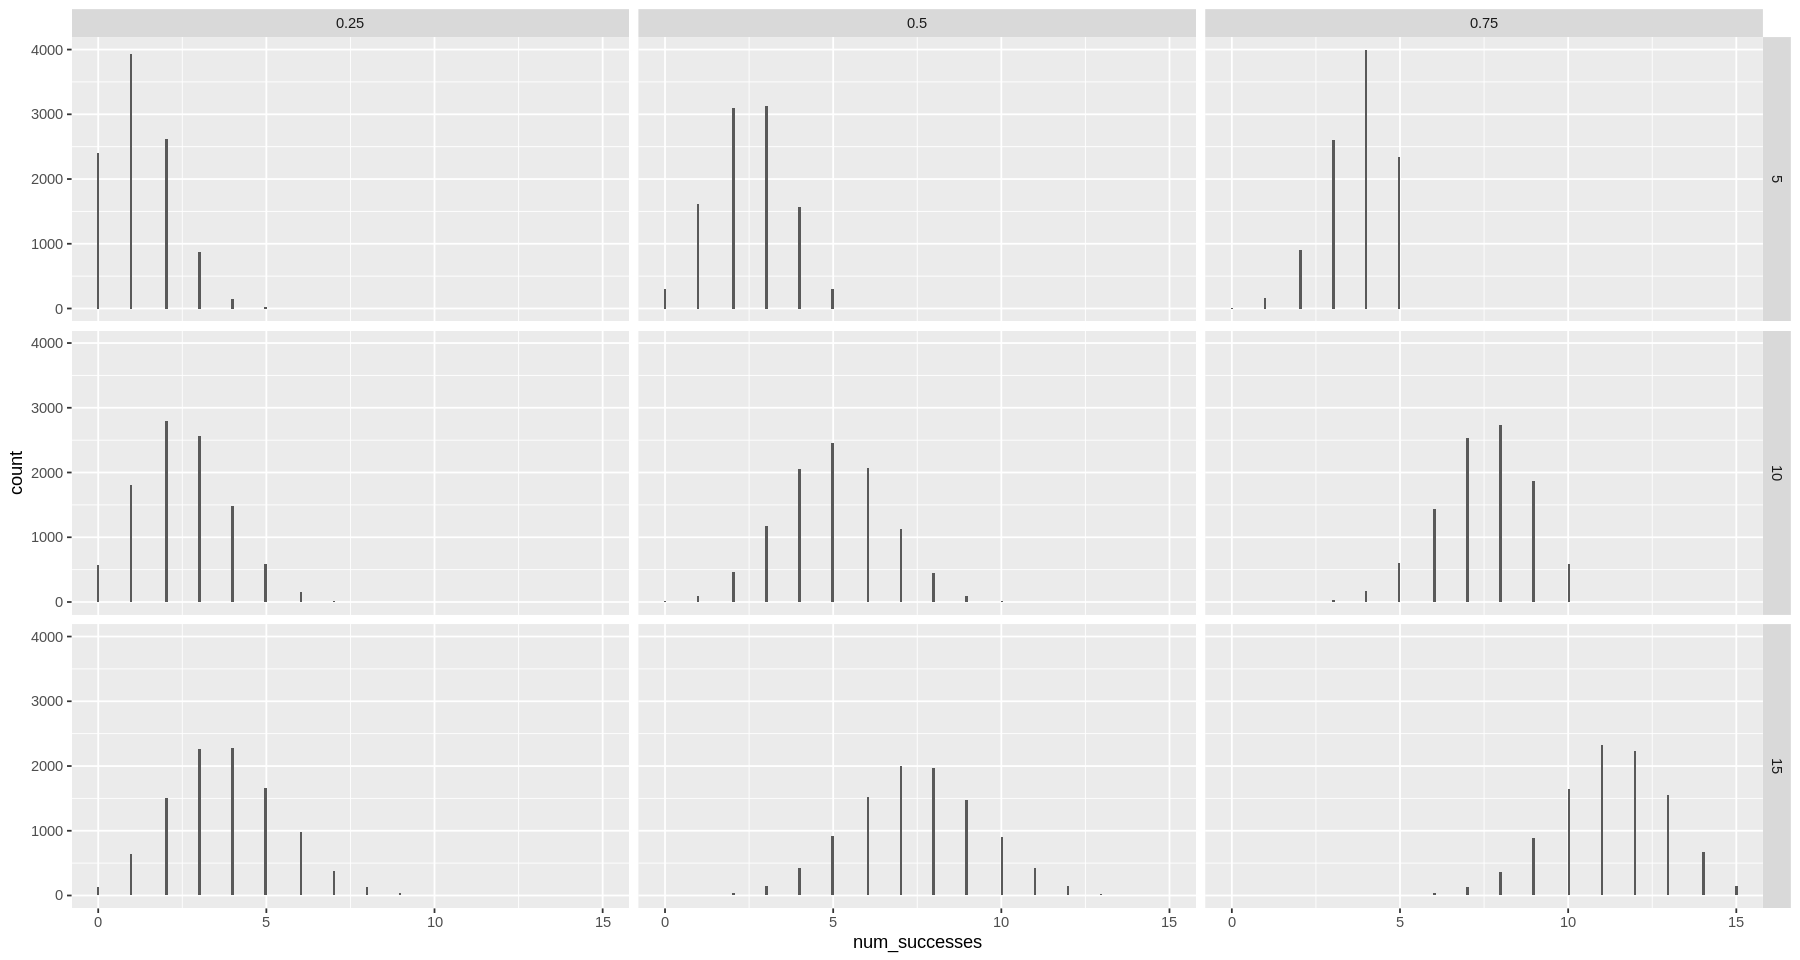

In [ ]:
num.trials <- 10000
(parameters(~n,         ~p,
            c(5,10,15), c(0.25, 0.5, 0.75))
 %>% add_trials(num.trials)
 %>% mutate(num_successes = map2_int(n, p, \(n, p) rbinom(1, n, p)))
 ) -> trials

# Make plots wider (Colab only)
options(repr.plot.width=15, repr.plot.height=8)

ggplot(trials) +
   geom_histogram(aes(x = num_successes), bins = 200) +
   facet_grid(rows = vars(n), cols = vars(p))

#### Plotting the empirical and theoretical CDFs

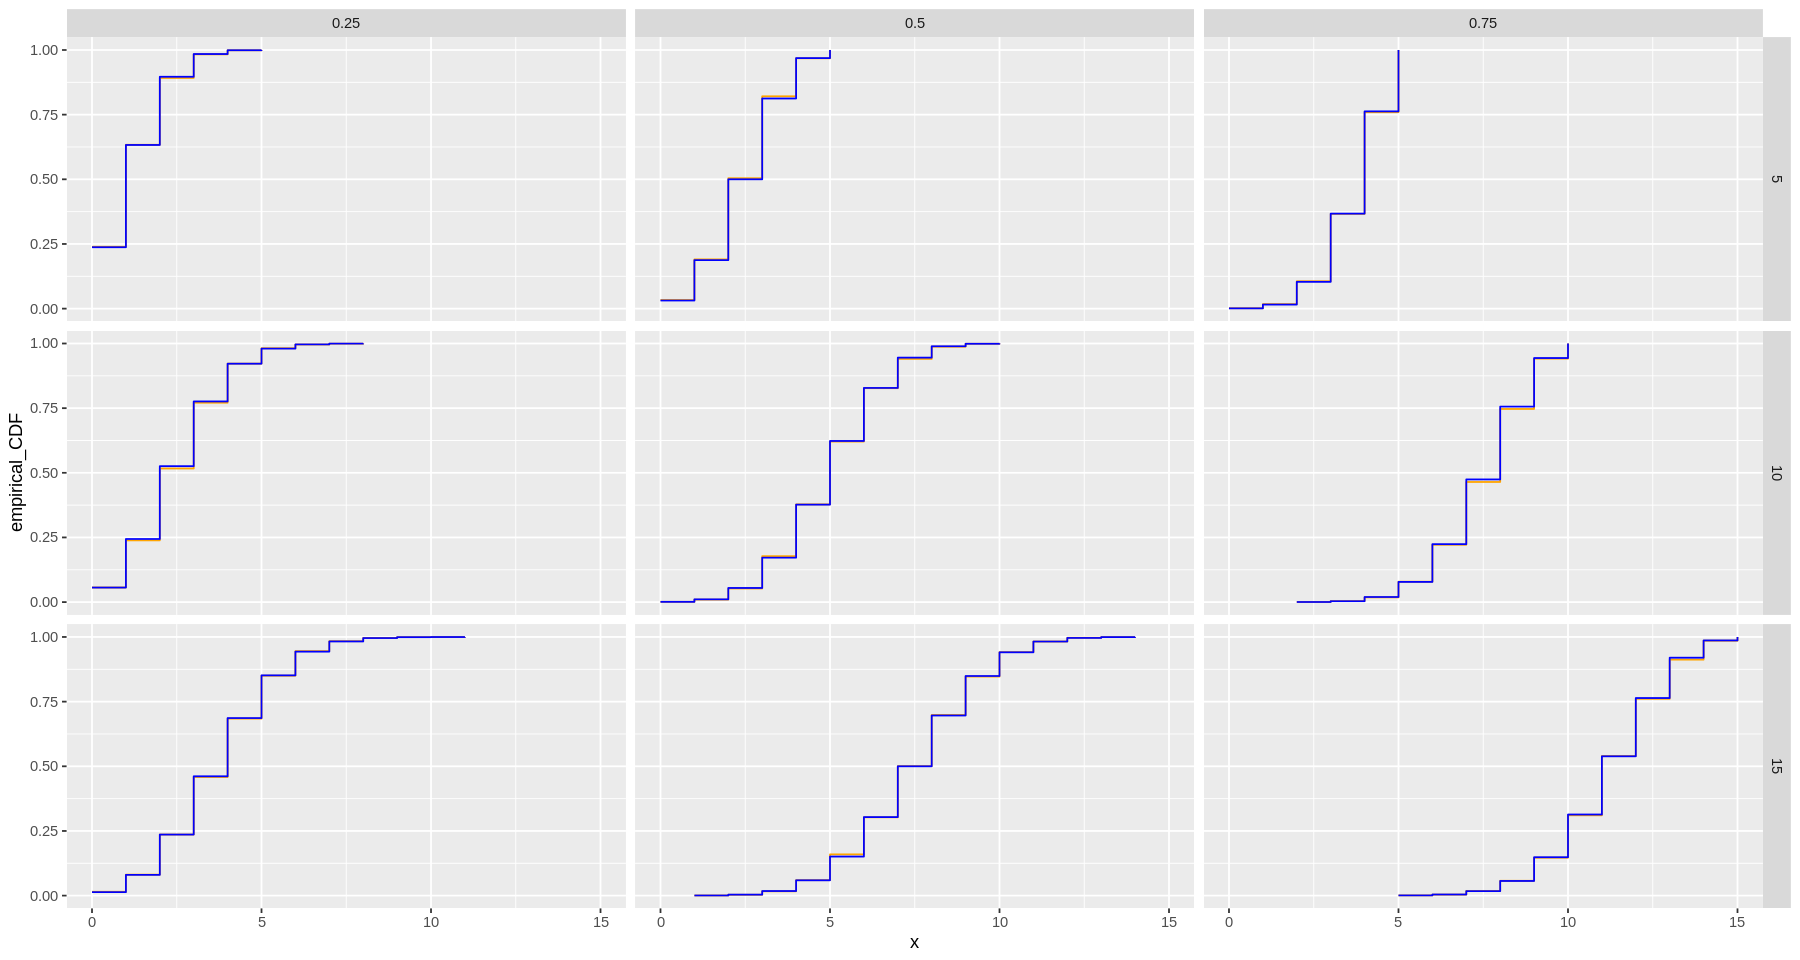

In [12]:
num.trials <- 10000
(parameters(~n,         ~p,
            c(5,10,15), c(0.25, 0.5, 0.75))
 %>% add_trials(num.trials)
 %>% mutate(x = map2_int(n, p, \(n, p) rbinom(1, n, p)))
 %>% mutate(empirical_CDF = cume_dist(x), .by = c(n, p))
 %>% mutate(theoretical_CDF = pmap_dbl(list(x, n, p), pbinom))
 ) -> two_param_CDF_data

# Make plots wider (Colab only)
options(repr.plot.width=15, repr.plot.height=8)

# prob_plot_data
 ggplot(data = two_param_CDF_data) +
   geom_step(aes(x = x, y = empirical_CDF), color = "orange") +
   geom_step(aes(x = x, y = theoretical_CDF), color = "blue") +
  #  geom_line(aes(x = x, y = theoretical_CDF), color = "blue") + $ For continuous RV
   facet_grid(rows = vars(n), cols = vars(p))

In [11]:
?geom_step

#### Creating a grid of p-p plots

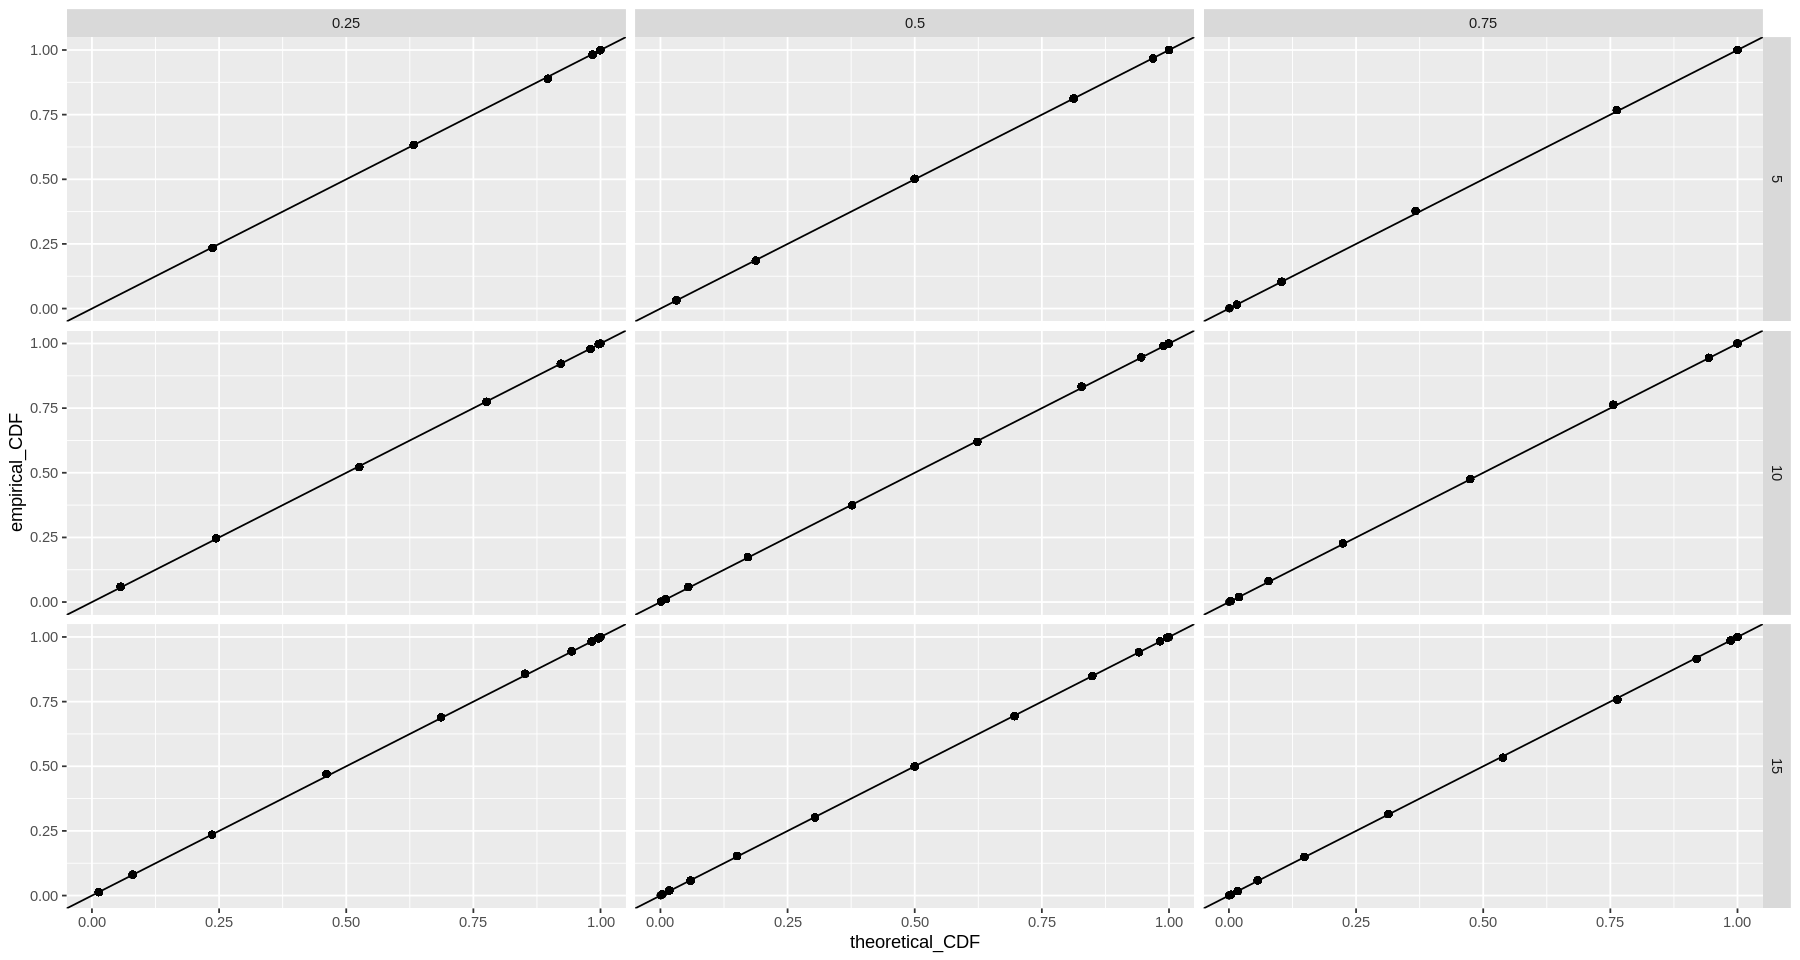

In [ ]:
ggplot(data = two_param_CDF_data) +
   geom_abline(aes(slope = 1, intercept = 0)) +
   geom_point(aes(x = theoretical_CDF, y = empirical_CDF)) +
   facet_grid(rows = vars(n), cols = vars(p))

## <font color="red"> Exercise 2.6.2 </font>

Let's return to the previous exercise, where we let $U_1, ..., U_k$ be a iid  $uniform(0,1)$ random variables and  let $W_k = \sum_{i=1}^k \frac{-\ln{U_i}}{\lambda}$, where $E_i$ are iid with $E_i\sim exponential(\lambda)$.  [It can be shown](https://en.wikipedia.org/wiki/Gamma_distribution#Random_variate_generation) that $W_k\sim gamma(\alpha = k, \beta = 1/\lambda)$

**Tasks.**

1. Run a parametric simulation over a grid of values for $k$ and $\lambda$ to verfiy the result.
2. Construct all three types of plots are part of your solution.

In [7]:
# Your code here